In [1]:
import sys
sys.path.append('../run_analyses/')

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from support.charting import primaryColors, fullColors, save_fig
from support.load import loadAllData, methodParams
from support.util import titles, order, methodTitle, modelTitle

from modelConfig import models
from util.util import getLeverNames

from ema_workbench import (Model, RealParameter, ScalarOutcome, Constant,
                           ema_logging, load_results, Policy, Scenario, 
                           MultiprocessingEvaluator)
from ema_workbench.analysis import parcoords
ema_logging.log_to_stderr(ema_logging.INFO)

def get_policies(archive):
    policies = []
    for i, row in archive.iterrows():
        policy = Policy(f'{i}', **row.to_dict())
        policies.append(policy)
    return policies

scenario = Scenario(**{'b': .42, 'delta': .98,
                   'mean': 0.02, 'q': 2, 'stdev': 0.0017})

In [2]:

def get_percentage_deviation(ref_results, results):
    ref_experiments, ref_outcomes = ref_results
    experiments, outcomes = results
    
    policy_scores = {}
    for policy in ref_experiments.policy.unique():
        logical = experiments.policy == int(policy)

        scores = {}
        for k, v in outcomes.items():
            v = v[logical]

            if k == 'max_P':
                v = np.percentile(v, 90)
            else:
                v = np.percentile(v, 10)

            difference = abs(v-ref_outcomes[k][int(policy)])
            average = (v + ref_outcomes[k][int(policy)])/2
            v = difference / average * 100
            scores[k] = v
        policy_scores[policy] = scores
    policy_scores = pd.DataFrame(policy_scores).T
    return policy_scores


def calculate_reference_perforrmance(model, policies):
    '''
    
    Parameters
    model : Model instance
    policies : DataFrame
    
    
    '''
    
    policies = get_policies(policies)
    
    
    with MultiprocessingEvaluator(model) as evaluator:
        ref_results = evaluator.perform_experiments(scenarios=scenario, policies=policies)
    
    return ref_results

# intertemporal


In [3]:
from ema_workbench import Model, RealParameter, ScalarOutcome, Constant
from modelData.intertemporal import lake_model

model = Model('intertemporal', function=lake_model)

model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2.0, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]
model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]
model.constants = [Constant('alpha', 0.41),
                   Constant('reps', 150)]

In [7]:
files = {'mordm':'../data/mordm/reevaluate/reevaluation_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.tar.gz',
         'multi-scenario MORDM 0':'../data/multi/reevaluate/reevaluation_intertemporal_NSGAIIHybrid_runs20_nfe500000_scenarios10000_refScenario-1.tar.gz',
         'multi-scenario MORDM 1':'../data/multi/reevaluate/reevaluation_intertemporal_NSGAIIHybrid_runs20_nfe500000_scenarios10000_refScenario0.tar.gz',
         'multi-scenario MORDM 2':'../data/multi/reevaluate/reevaluation_intertemporal_NSGAIIHybrid_runs20_nfe500000_scenarios10000_refScenario1.tar.gz',
         'multi-scenario MORDM 3':'../data/multi/reevaluate/reevaluation_intertemporal_NSGAIIHybrid_runs20_nfe500000_scenarios10000_refScenario2.tar.gz',
         'multi-scenario MORDM 4':'../data/multi/reevaluate/reevaluation_intertemporal_NSGAIIHybrid_runs20_nfe500000_scenarios10000_refScenario3.tar.gz',
         'MORO':'../data/moro/reevaluate/reevaluation_intertemporal_NSGAIIHybrid_runs10_nfe300000_scenarios10000_refScenario-1.tar.gz'}

scores = {}
for k, fn in files.items():
    results = load_results(fn)
    experiments, outcomes = results
    policies = experiments.drop_duplicates('policy').iloc[:, 5:105]
    policies = policies.reset_index(drop=True)
    ref_results = calculate_reference_perforrmance(model, policies)
    policy_scores = get_percentage_deviation(ref_results, results)
    scores[k] = policy_scores

[MainProcess/INFO] results loaded succesfully from /Users/jhkwakkel/Documents/workspace/RobustDecisionSupportComparison/data/mordm/reevaluate/reevaluation_intertemporal_NSGAIIHybrid_runs50_nfe500000_scenarios10000_refScenario-1.tar.gz
[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1 scenarios * 90 policies * 1 model(s) = 90 experiments
[MainProcess/INFO] 9 cases completed
[MainProcess/INFO] 18 cases completed
[MainProcess/INFO] 27 cases completed
[MainProcess/INFO] 36 cases completed
[MainProcess/INFO] 45 cases completed
[MainProcess/INFO] 54 cases completed
[MainProcess/INFO] 63 cases completed
[MainProcess/INFO] 72 cases completed
[MainProcess/INFO] 81 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results loaded succesfully from /Users/jhkwakkel/Documents/workspace/RobustDecisionSupportComparison/data/multi/reevaluate/reevaluation_intertemporal_NSGAIIHybrid_runs20_nfe

In [8]:
a = pd.concat(scores.values(), ignore_index=True)
a.head()

,max_P,utility,inertia,reliability
0,124.893159,102.691546,0.000000e+00,140.120695
1,126.312265,103.686995,0.000000e+00,144.223994
2,126.381012,102.797531,0.000000e+00,144.598336
3,118.536241,95.618477,0.000000e+00,101.423389
4,119.044480,97.056674,1.121552e-14,104.909287


In [22]:
data = {'MORDM':scores['mordm'],
        'multi-scenario MORDM' : pd.concat([scores[f'multi-scenario MORDM {i}'] for i in range(5)], ignore_index=True),
        'MORO':scores['MORO']}


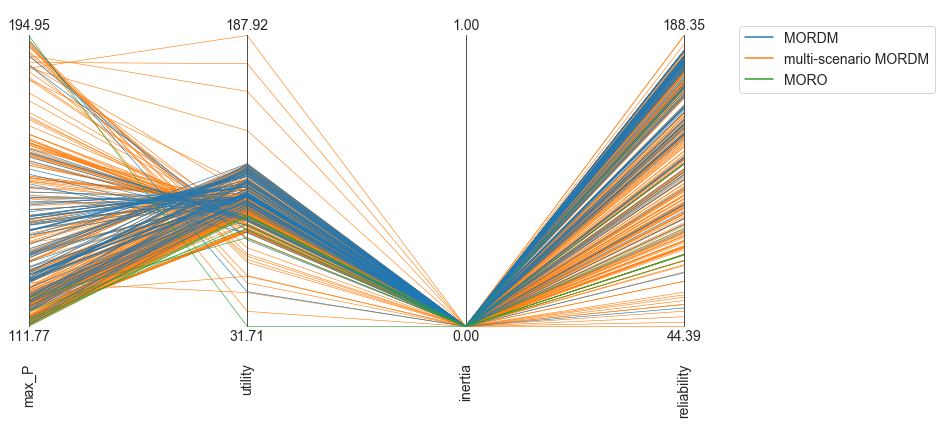

In [33]:

colors = iter(sns.color_palette())

limits = parcoords.get_limits(pd.concat(data.values()))
limits.inertia = [0,1]

paraxes = parcoords.ParallelAxes(limits)

for zorder, (k, v) in zip([5, 0, 10], data.items()):
#     if k.startswith('multi'):
#         zorder = 0
#     else:
#         zorder=10
    
    paraxes.plot(v, color=next(colors), lw=.6, alpha=1, label=k, zorder=zorder)

    fig = plt.gcf()
    fig.set_size_inches(10,6)

paraxes.legend()

fig = plt.gcf()
change_fontsize(fig, 14)
save_fig(fig, './images/', 'perc_dev_intertemporal')

plt.show()

# planned adaptive

In [37]:
from modelData.planned_adaptive import lake_model

model = Model('plannedadaptive', function=lake_model)

model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2.0, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]
model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]
model.constants = [Constant('alpha', 0.41),
                   Constant('reps', 150)]

In [38]:
import os

files = {'MORDM':'../data/mordm/reevaluate/reevaluation_plannedadaptive_NSGAIIHybrid_runs50_nfe100000_scenarios10000_refScenario-1.tar.gz',
         'multi-scenario MORDM 0':'../data/multi/reevaluate/reevaluation_plannedadaptive_NSGAIIHybrid_runs20_nfe100000_scenarios10000_refScenario-1.tar.gz',
         'multi-scenario MORDM 1':'../data/multi/reevaluate/reevaluation_plannedadaptive_NSGAIIHybrid_runs20_nfe100000_scenarios10000_refScenario0.tar.gz',
         'multi-scenario MORDM 2':'../data/multi/reevaluate/reevaluation_plannedadaptive_NSGAIIHybrid_runs20_nfe100000_scenarios10000_refScenario1.tar.gz',
         'multi-scenario MORDM 3':'../data/multi/reevaluate/reevaluation_plannedadaptive_NSGAIIHybrid_runs20_nfe100000_scenarios10000_refScenario2.tar.gz',
         'multi-scenario MORDM 4':'../data/multi/reevaluate/reevaluation_plannedadaptive_NSGAIIHybrid_runs20_nfe100000_scenarios10000_refScenario3.tar.gz',
         'MORO':'../data/moro/reevaluate/reevaluation_plannedadaptive_NSGAIIHybrid_runs10_nfe100000_scenarios10000_refScenario-1.tar.gz'}

scores = {}
for k, fn in files.items():
    results = load_results(fn)
    experiments, outcomes = results
    policies = experiments.drop_duplicates('policy').iloc[:, 5:10]
    policies = policies.reset_index(drop=True)
    ref_results = calculate_reference_perforrmance(model, policies)
    policy_scores = get_percentage_deviation(ref_results, results)
    scores[k] = policy_scores

[MainProcess/INFO] results loaded succesfully from /Users/jhkwakkel/Documents/workspace/RobustDecisionSupportComparison/data/mordm/reevaluate/reevaluation_plannedadaptive_NSGAIIHybrid_runs50_nfe100000_scenarios10000_refScenario-1.tar.gz
[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1 scenarios * 48 policies * 1 model(s) = 48 experiments
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 25 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 35 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 45 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results loaded succesfully from /Users/jhkwakkel/Documents/workspace/RobustDecisionSupportComparison/data/multi/reevaluate/reevaluation_plannedadaptive_NSGAIIHybrid_runs20_nfe100000_scenarios10000_refScenario-

In [41]:
data = {'MORDM':scores['MORDM'],
        'multi-scenario MORDM' : pd.concat([scores[f'multi-scenario MORDM {i}'] for i in range(5)], ignore_index=True),
        'MORO':scores['MORO']}



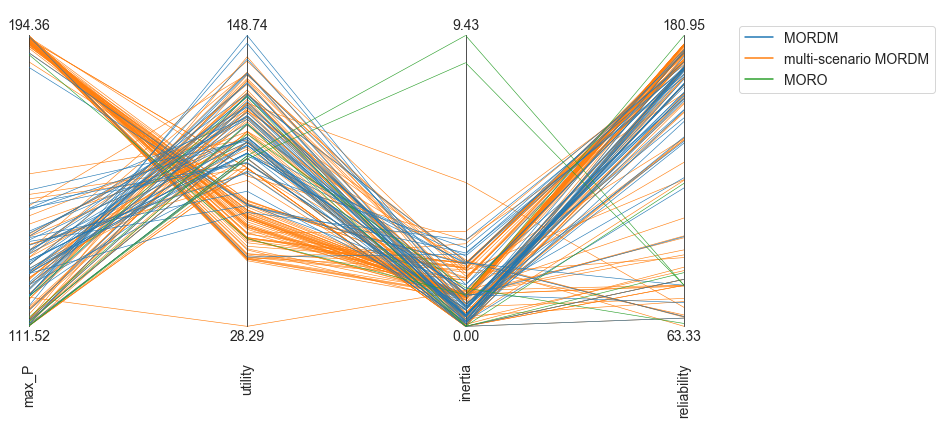

In [44]:

colors = iter(sns.color_palette())

limits = parcoords.get_limits(pd.concat(data.values()))

paraxes = parcoords.ParallelAxes(limits)

for zorder, (k, v) in zip([5, 0, 10], data.items()):
    paraxes.plot(v, color=next(colors), lw=.6, alpha=1, label=k, zorder=zorder)

    fig = plt.gcf()
    fig.set_size_inches(10,6)

paraxes.legend()

fig = plt.gcf()
change_fontsize(fig, 14)
save_fig(fig, './images/', 'perc_dev_plannedadaptive')

plt.show()

# DPS

In [45]:
from modelData.dps import lake_model

model = Model('dps', function=lake_model)

model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2.0, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]
model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]
model.constants = [Constant('alpha', 0.41),
                   Constant('reps', 150)]

In [46]:
import os

files = {'MORDM':'../data/mordm/reevaluate/reevaluation_dps_NSGAIIHybrid_runs50_nfe100000_scenarios10000_refScenario-1.tar.gz',
         'multi-scenario MORDM 0':'../data/multi/reevaluate/reevaluation_dps_NSGAIIHybrid_runs20_nfe100000_scenarios10000_refScenario-1.tar.gz',
         'multi-scenario MORDM 1':'../data/multi/reevaluate/reevaluation_dps_NSGAIIHybrid_runs20_nfe100000_scenarios10000_refScenario0.tar.gz',
         'multi-scenario MORDM 2':'../data/multi/reevaluate/reevaluation_dps_NSGAIIHybrid_runs20_nfe100000_scenarios10000_refScenario1.tar.gz',
         'multi-scenario MORDM 3':'../data/multi/reevaluate/reevaluation_dps_NSGAIIHybrid_runs20_nfe100000_scenarios10000_refScenario2.tar.gz',
         'multi-scenario MORDM 4':'../data/multi/reevaluate/reevaluation_dps_NSGAIIHybrid_runs20_nfe100000_scenarios10000_refScenario3.tar.gz',
         'MORO':'../data/moro/reevaluate/reevaluation_dps_NSGAIIHybrid_runs10_nfe100000_scenarios10000_refScenario-1.tar.gz'}

scores = {}
for k, fn in files.items():
    results = load_results(fn)
    experiments, outcomes = results
    policies = experiments.drop_duplicates('policy').iloc[:, 5:10]
    policies = policies.reset_index(drop=True)
    
    ref_results = calculate_reference_perforrmance(model, policies)
    policy_scores = get_percentage_deviation(ref_results, results)
    scores[k] = policy_scores

[MainProcess/INFO] results loaded succesfully from /Users/jhkwakkel/Documents/workspace/RobustDecisionSupportComparison/data/mordm/reevaluate/reevaluation_dps_NSGAIIHybrid_runs50_nfe100000_scenarios10000_refScenario-1.tar.gz
[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1 scenarios * 110 policies * 1 model(s) = 110 experiments
[MainProcess/INFO] 11 cases completed
[MainProcess/INFO] 22 cases completed
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 44 cases completed
[MainProcess/INFO] 55 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 77 cases completed
[MainProcess/INFO] 88 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] 110 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results loaded succesfully from /Users/jhkwakkel/Documents/workspace/RobustDecisionSupportComparison/data/multi/reevaluate/reevaluation_dps_NSGAIIHybrid_runs20_nfe100000_scenarios

In [47]:
data = {'MORDM':scores['MORDM'],
        'multi-scenario MORDM' : pd.concat([scores[f'multi-scenario MORDM {i}'] for i in range(5)], ignore_index=True),
        'MORO':scores['MORO']}

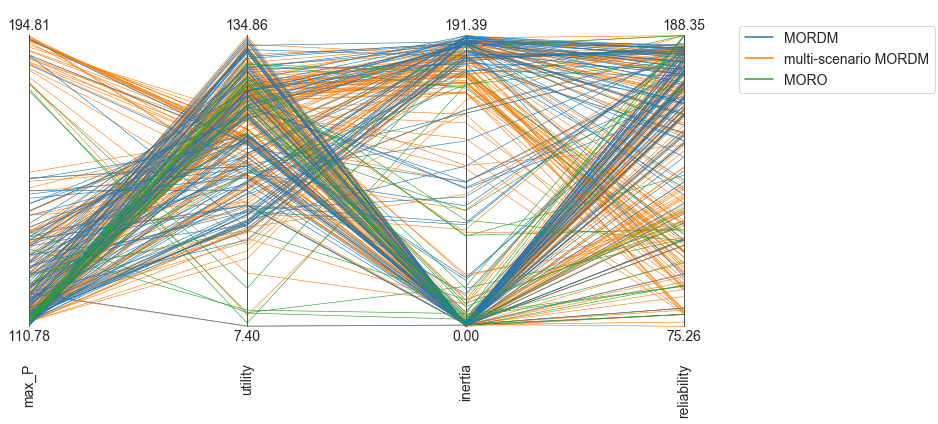

In [48]:
colors = iter(sns.color_palette())

limits = parcoords.get_limits(pd.concat(data.values()))

paraxes = parcoords.ParallelAxes(limits)

for zorder, (k, v) in zip([5, 0, 10], data.items()):
    paraxes.plot(v, color=next(colors), lw=.6, alpha=1, label=k, zorder=zorder)

    fig = plt.gcf()
    fig.set_size_inches(10,6)

paraxes.legend()

fig = plt.gcf()
change_fontsize(fig, 14)
save_fig(fig, './images/', 'perc_dev_plannedadaptive')

plt.show()